# Sanctions Risk Index (SRI) for russian financial market 
SRI is constructed using news sentiment analysis to explain the dynamics of russian financial market variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
from itertools import combinations

from tqdm.notebook import tqdm, trange
from pygooglenews import GoogleNews

import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer, SentiText

from arch.univariate import LS, ARX, ARCH, GARCH

## Specify words for google query
We need to find all news about russian financial market, which can be affected by sanctions. 

In [2]:
words_market = ['russian rouble', 'the rouble', 'russian currency', 'ofz', 'russian bonds', 'RUBUTSTN=MCX']
query = ' OR '.join(['\"'+x+'\"' for x in words_market])

## Load news 

News are loaded with 'pygooglenews' library. 

Query output is limited by 100 items, so no possibility to load all news for the long period of time at once. In the code below queries are made for a shorter periods of time of length 'step' days. 

In [3]:
# Settings
start_date = dt.datetime(2012, 1, 1) # start date 
end_date = dt.datetime.today() # end date
step_initial = 30

# Preprocessing and initialization
tot = int(np.ceil((end_date-start_date).days / step_initial))
news_df = pd.DataFrame(columns=['date', 'title'])
step = step_initial # number of days for each query
start_date_i = start_date # start date for each iteration
pbar = trange(tot)

# Loop over rows of 'step' days and query google news
cond = True
while cond:
    # Make a query
    gn = GoogleNews(lang = 'en') 
    items = gn.search(query, \
                      helper = False,\
                      from_ = start_date_i.strftime('%Y-%m-%d'),\
                      to_ = (start_date_i+dt.timedelta(step-1)).strftime('%Y-%m-%d'))
    
    # If number of items is equal to the max value of items in the query output, 
    # some items may be missed, so divide step by 2 and repeat 
    if len(items['entries']) == 100:    
        # divide step by 2
        step = max(int(step/2), 1)
        
        # update tqdm bar 
        pbar.total = pbar.n +int(np.ceil(((end_date - start_date_i).days - step) / \
                                        step_initial) + 1)
        pbar.refresh()
        
        continue
        
    # If number of items is positive, but less than 100, save them into news_df
    if len(items['entries'])>0:
        items_df = pd.DataFrame(items['entries'])[['published_parsed', 'title']]
        items_df.columns = ['date', 'title']
        items_df.date = items_df.date.apply(lambda x: dt.datetime(*x[:6]))
        news_df = pd.concat([news_df, items_df]).drop_duplicates()
        
    # Add step to the start_date_i
    start_date_i = start_date_i + dt.timedelta(step)
    
    # Update progress bar
    pbar.update(1)
    pbar.set_postfix(start_date = start_date_i.strftime('%d.%m.%y'), news_total = len(news_df))
    
    # Reset step
    step = step_initial
    
    # If current start_date is bigger than final end_date, break the loop
    if start_date_i > end_date:
        cond = False

  0%|          | 0/116 [00:00<?, ?it/s]

### Process news_df dataframe

In [4]:
news_df.reset_index(drop = True, inplace = True)
news_df.date = pd.to_datetime(news_df.date.dt.date)
news_df.sort_values(by = 'date', inplace = True)
news_df.drop_duplicates(inplace = True)
news_df.title = news_df.title.str.lower()

### Estimate news sentiment

Sentiment takes values from -1 (totally positive) to 1 (totally negative).

In [5]:
analyser = SentimentIntensityAnalyzer()
for i, row in news_df.iterrows():
    news_df.loc[i, 'sentiment'] = -analyser.polarity_scores(news_df.loc[i, 'title'])['compound']
    
news_df.sentiment = news_df.sentiment.fillna(0)
news_df.set_index('date', inplace=True)

### Construct Sanctions Risk Index (SRI)
SRI is constructed for each day in the following way:
\begin{equation}
\begin{split}
SRI &= (1-w) \cdot attention + w \cdot sentiment,
\end{split}
\end{equation}
where $attention$ is the share of news where specified sanction words are presented, $sentiment$ is statistic calculated in the previous step and averaged for each day (only for news filtered in the previous step), and $w$ is the weight of $sentiment$ relative to $attention$.

In [6]:
# Settings
sr_words = ['sanction', 'geopolitic', 'poison', 'biden'] # sanctions risk words
w = 0.82 # weight of sentiment

# Choose the news where any of sr_words are presented
cond = news_df.title.str.contains('|'.join(sr_words))
news_sr_df = news_df[cond]

# Calculate attention, sentiment and SRI value for each day
sri_df = pd.DataFrame(columns = ['attention', 'sentiment', 'sri_raw', 'sri'])
sri_df.attention = news_sr_df.groupby('date').title.count()/news_df.groupby('date').title.count()
sri_df.attention = sri_df.attention.fillna(0)
sri_df.sentiment = news_sr_df.groupby('date').sentiment.mean()
sri_df.sentiment = sri_df.sentiment.fillna(0)
sri_df.sri = (1-w)*sri_df.attention + w*sri_df.sentiment

# Calculate statistics for each sanction risk word
for word in sr_words:
    cond = news_df.title.str.contains(word)
    news_sanctions = news_df[cond]
    
    df = pd.DataFrame(columns = ['attention', 'sentiment', 'sri_raw', 'sri'])
    df.attention = news_sr_df.groupby('date').title.count()/news_df.groupby('date').title.count()
    df.attention = df.attention.fillna(0)
    df.sentiment = news_sr_df.groupby('date').sentiment.mean()
    df.sentiment = df.sentiment.fillna(0)
    df.sri = (1-w)*df.attention + w*df.sentiment

    sri_df[word] = df.sri

### USDRUB and SRI
Check that differences of SRI explaines the dynamic of USDRUB log returns in GARCH(1, 1) model with Brent prices, CDS and VIX index as additional exogenous variables.

Choose the value of parameter $w$ to maximuze $R^2$ of the model:

In [7]:
# Load data (source: investing.com, Reuters)
usdrub_df = pd.read_csv('data.csv', sep = ';', index_col = 0)
usdrub_df.index = pd.to_datetime(usdrub_df.index)
usdrub_df['usdrub_dlog'] = np.insert(np.diff(np.log(usdrub_df['USDRUB'])), 0, np.nan)
usdrub_df['brent_dlog'] = np.insert(np.diff(np.log(usdrub_df['BRENT'])), 0, np.nan)
usdrub_df['vix_dlog'] = np.insert(np.diff(np.log(usdrub_df['VIX'])), 0, np.nan)
usdrub_df['cds_dlog'] = np.insert(np.diff((usdrub_df['CDS']/100)), 0, np.nan)
usdrub_df = usdrub_df.merge(sri_df['sri'], left_index = True, right_index = True)
usdrub_df = usdrub_df*100

# Initialization
w_ar = np.arange(101)/100
n = len(w_ar)
rsq_best = 0

# Loop over w_ar to choose optimal w 
pbar = trange(n)
for w in w_ar:
    # Calculate SRI and add to the dataframe
    sri_df.sri = (1-w)*sri_df.attention + w*sri_df.sentiment
    usdrub_df.drop('sri', axis = 1, inplace = True)
    usdrub_df = usdrub_df.merge(sri_df['sri'], left_index = True, right_index = True)
    usdrub_df['sri_dlog'] = np.insert(np.diff((usdrub_df['sri'])), 0, np.nan)*100
    usdrub_df.dropna(inplace = True)
    
    # Estimate GARCH model
    ar = LS(usdrub_df['usdrub_dlog'], usdrub_df[['sri_dlog', 'vix_dlog', 'brent_dlog', 'cds_dlog']])
    ar.volatility = GARCH(1,1)
    ar = ar.fit(disp = 'off')
    rsq = ar.rsquared
    pval = ar.pvalues['sri_dlog']
    
    # If SRI is significant and R^2 is higher than for the other models
    # with significant SRI, accept the model
    if (rsq > rsq_best) & (pval < 0.1):
        rsq_best = rsq
        w_best = w
        model_best = ar
        pbar.set_postfix(rsq = rsq_best, pval = pval, w = w)

    pbar.update(1)

  0%|          | 0/101 [00:00<?, ?it/s]

Calculate SRI. 

In [8]:
w = 1

sri_df.sri = (1-w)*sri_df.attention + w*sri_df.sentiment
usdrub_df.drop('sri', axis = 1, inplace = True)
usdrub_df = usdrub_df.merge(sri_df['sri'], left_index = True, right_index = True)
usdrub_df['sri_dlog'] = np.insert(np.diff((usdrub_df['sri'])), 0, np.nan)*100
usdrub_df.dropna(inplace = True)

ar = LS(usdrub_df['usdrub_dlog'], usdrub_df[['sri_dlog', 'vix_dlog', 'brent_dlog', 'cds_dlog']])
ar.volatility = GARCH(1,1)
ar = ar.fit(disp = 'off')
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Least Squares - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:            usdrub_dlog   R-squared:                       0.254
Mean Model:             Least Squares   Adj. R-squared:                  0.252
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1604.50
Distribution:                  Normal   AIC:                           3227.00
Method:            Maximum Likelihood   BIC:                           3273.44
                                        No. Observations:                 1287
Date:                Thu, Jul 08 2021   Df Residuals:                     1282
Time:                        14:52:57   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0174  2.171e-02      0.802      0.423 [-2.514e-02,5.994e-02]
sri_dlog   3.9562e-03  1.352e-03      2.926  3.438e-03  [1.306e-03,6.607e-03]
vix_dlog       0.0274  2.937e-03      9.330  1.062e-20  [2.165e-02,3.316e-02]
brent_dlog    -0.1132  1.443e-02     -7.841  4.463e-15   [ -0.141,-8.488e-02]
cds_dlog   1.7047e-03  9.679e-04      1.761  7.821e-02 [-1.924e-04,3.602e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0333  2.072e-02      1.605      0.108 [-7.352e-03,7.387e-02]
alpha[1]       0.1454  5.033e-02      2.889  3.866e-03    [4.675e-02,  0.244]
gamma[1]      -0.0744  3.746e-02     -1.985  4.710e-02   [ -0.148,-9.526e-04]
beta[1]        0.8512  5.416e-02     15.716  1.172e-55      [  0.745,  0.957]
=============================================================================

Covariance estimator: robust
"""

Differences of SRI significantly (at 0.01 significance level) and positively affect USDRUB log returns.

### SRI vizualization
Calculate expnonential weighted moving average (with half-life parameter $h$ set to 300 days) to vizualize SRI index.

In [9]:
h = 300
sri_df['sri_ewm'] = sri_df['sri'].ewm(span = h).mean()*100

Plot

Text(2021-01-20 00:00:00, 0.9539323778501557, 'Arrest of Navalny \n')

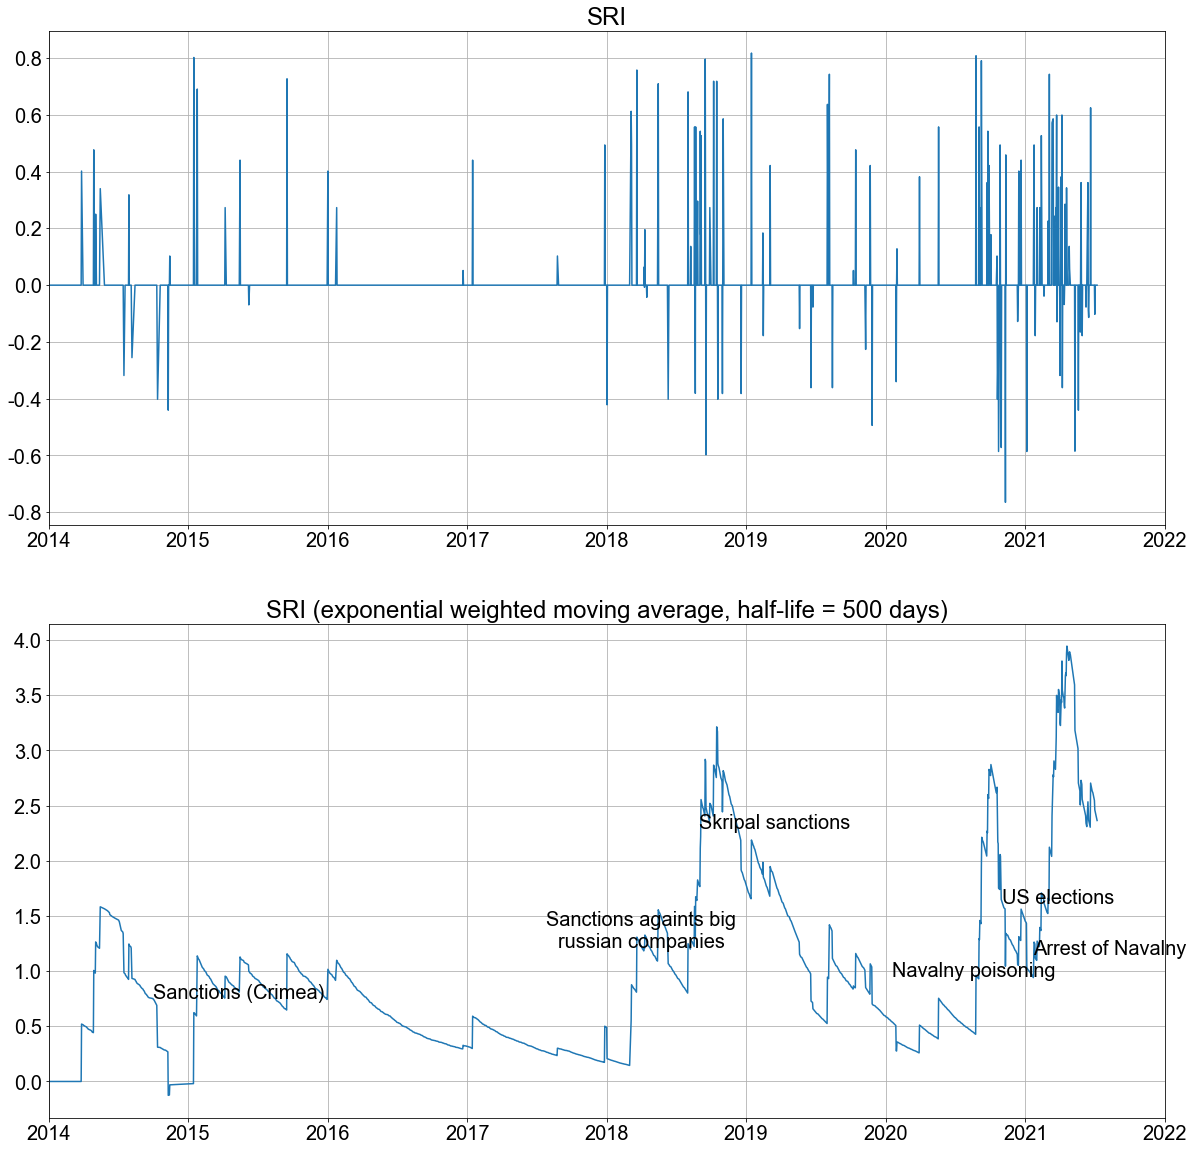

In [10]:
def WrapText(txt):
    cnt=0
    cnt_max=2
    words = txt.split(' ')
    sent = ''
    for word in words:
        if cnt<cnt_max:
            sent+=word+' '
            cnt+=1
        else:
            sent+=word+' \n'
            cnt=0
    return sent

matplotlib.rcParams.update({'font.size': 20, 'font.family':'sans-serif', 'font.sans-serif':'Arial'})

fig, ax = plt.subplots(2, figsize=(20, 20), )
ax[0].plot(sri_df['sri'])
ax[0].set_title('SRI')
ax[0].set_xlim(dt.datetime(2014, 1, 1), dt.datetime(2022, 1, 1))
ax[0].set_xlabel('')
ax[0].tick_params(axis = 'x', labelrotation = 0)
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax[0].grid()

ax[1].plot(sri_df['sri_ewm'])
ax[1].set_title('SRI (exponential weighted moving average, half-life = 500 days)')
ax[1].set_xlim(dt.datetime(2014, 1, 1), dt.datetime(2022, 1, 1))
ax[1].set_xlabel('')
ax[1].tick_params(axis = 'x', labelrotation = 0)
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax[1].grid()
      
# Add main sanctions event labels to the plot
date = dt.datetime(2014, 10, 1)
ax[1].text(date, sri_df['sri_ewm'][date], WrapText('Sanctions (Crimea)'))
date = dt.datetime(2018, 4, 9)
ax[1].text(date, sri_df['sri_ewm'][date], WrapText('Sanctions againts big russian companies'), ha='center')
date = dt.datetime(2018, 8, 30)
ax[1].text(date, sri_df['sri_ewm'][date]+0.5, WrapText('Skripal sanctions'))
date = dt.datetime(2020, 8, 26)
ax[1].text(date, sri_df['sri_ewm'][date], WrapText('Navalny poisoning'), ha='center')
date = dt.datetime(2020, 11, 2)
ax[1].text(date, sri_df['sri_ewm'][date], WrapText('US elections'))
date = dt.datetime(2021, 1, 20)
ax[1].text(date, sri_df['sri_ewm'][date], WrapText('Arrest of Navalny'))